<a href="https://colab.research.google.com/github/kamilamyslinska/Natural-Language-Processing-NLP/blob/main/Clustering_with_users_who_have_used_hexeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Clustering with users who have used #hexeline.ipynb

In [1]:
import requests 
import re
import pandas as pd
from matplotlib import pyplot as plt
from random import randint
import numpy as np
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

####File loading
The data comes from Instagram and concerns the Lodz-based clothing company Hexeline. These are data scraped from the company's public profile.

In [2]:
df = pd.read_csv('hashtaghexeline.csv')
df.sample(3)

,postUrl,profileUrl,username,fullName,commentCount,likeCount,pubDate,description,location,imgUrl,postId,ownerId,type,query,timestamp,isSidecar,sidecarMedias,videoUrl,viewCount
710,https://www.instagram.com/p/BVHQCaLgsLl/,https://www.instagram.com/fashion_coco_club,fashion_coco_club,COCO SALON ODZIEZOWY,0,17,2017-06-09T09:10:21.000Z,Sukienkazkapturem#moda #Hexeline#,NaN,https://scontent-lhr8-1.cdninstagram.com/v/t51...,1.533265e+18,3.836613e+09,Photo,NaN,2022-09-16T14:36:16.655Z,False,NaN,NaN,NaN
637,https://www.instagram.com/p/BlHvmLhH33v/,https://www.instagram.com/fashion_coco_club,fashion_coco_club,COCO SALON ODZIEZOWY,0,17,2018-07-12T06:08:25.000Z,Przecena #zakupy#hexeline#paola#emoi#feria#skl...,NaN,https://scontent-lhr8-1.cdninstagram.com/v/t51...,1.821634e+18,3.836613e+09,Photo,NaN,2022-09-16T14:36:05.534Z,False,NaN,NaN,NaN
384,https://www.instagram.com/p/B6pwcyUlzWi/,https://www.instagram.com/centrumgalaxy,centrumgalaxy,Galaxy — największe Centrum Handlowo-Rozrywkow...,0,13,2019-12-29T10:09:20.000Z,Green or red ❓ #hexe #hexeline #shopping #dres...,NaN,https://scontent-lhr8-1.cdninstagram.com/v/t51...,2.209510e+18,3.046837e+09,Photo,NaN,2022-09-16T14:35:31.719Z,False,NaN,NaN,NaN


In [3]:
df['username'] = df['username'].apply(lambda x: str(x).lower())

In [4]:
df['description'] = df['description'].apply(lambda x: str(x).lower())

Users who have used #hexeline without a profile Hexeline

In [5]:
df=df[~df.username.str.startswith(('hexeline'))]

In [6]:
user=df['username']

In [7]:
user=user.to_list()

####Hashtags

In [10]:
df_new = df[df['description'].notnull()]

In [11]:
df_new['hashtags'] = df_new['description'].apply(lambda x: [t for t in x.split() if t.startswith('#')])

In [12]:
hashtags = df_new['hashtags']

In [13]:
hash_list = [item for sublist in hashtags for item in sublist]

hash_freq = pd.Series(hash_list).value_counts()

In [14]:
hash_freq[:7]

#hexeline      367
#fashion       142
#moda           66
#style          56
#polishgirl     50
#campaign       39
#shopping       38
dtype: int64

###Clustering

In [15]:
X = hashtags
y = user

In [16]:
X = X.apply(lambda x: str(x).lower())

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

In [19]:
X.shape

(470, 2002)

In [20]:
X = X.toarray()

In [21]:
y = tfidf.fit_transform(y)

In [22]:
y.shape

(470, 203)

In [23]:
y = y.toarray()

####PCA

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X)
 
print(f'Number of components: {pca.n_components_}')

Number of components: 195


In [26]:
X = X_pca

###model DBSCAN

In [27]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs

In [28]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

In [29]:
db = DBSCAN(eps=0.2, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.2f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.2f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.2f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.2f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.2f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.2f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 105
Homogeneity: 0.86
Completeness: 0.70
V-measure: 0.77
Adjusted Rand Index: 0.78
Adjusted Mutual Information: 0.77
Silhouette Coefficient: 0.52


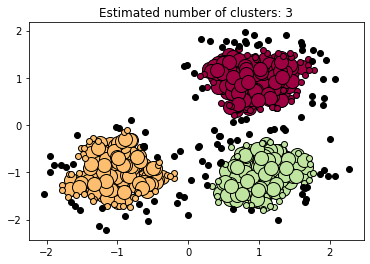

In [30]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

####Hierarchical clustering

In [31]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering().fit(X)
clustering

AgglomerativeClustering()

In [32]:
clustering.labels_

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [33]:
from sklearn.metrics import pairwise_distances

In [34]:
n_clusters = 5
labels=X

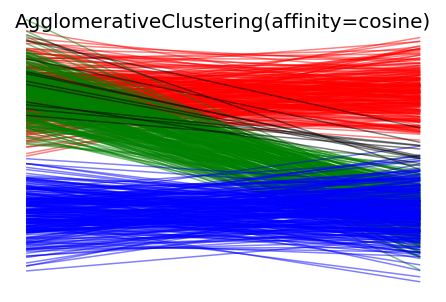

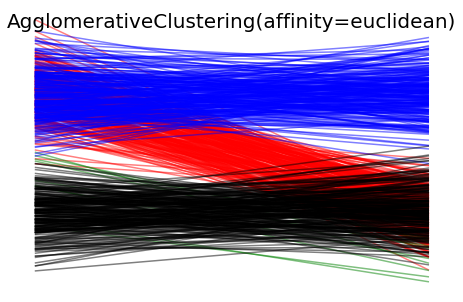

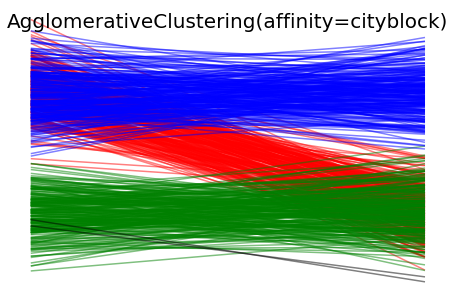

In [35]:
# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(
        n_clusters=n_clusters, linkage="average", affinity=metric
    )
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), "rgbk"):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=0.5)
    plt.axis("tight")
    plt.axis("off")
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)

In [36]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [37]:
mergings = linkage(X, method='complete')

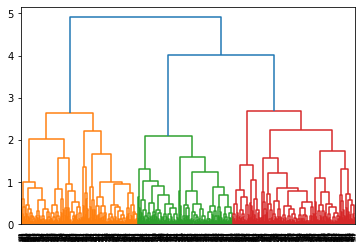

In [38]:
dendrogram(mergings)
plt.show()

In [39]:
labels = fcluster(mergings, 1, criterion='distance')

df_dendrom1= pd.Series(labels)
print(df_dendrom1.sample(3))

366    15
722     8
652    13
dtype: int32


###KMeans

In [40]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=5, max_iter=1000, random_state=42)

model.fit(X)
 
print(model.cluster_centers_)

[[ 1.26608124 -0.81788933]
 [ 1.34967631  1.05732694]
 [-1.03975939 -1.00916716]
 [ 0.68091207  0.96668935]
 [ 0.75057844 -1.26545846]]


In [41]:
label = model.labels_

In [42]:
y_kmeans = model.predict(X)

In [43]:
from multiprocessing.dummy import Pool
from sklearn.cluster import KMeans
import functools

kmeans = KMeans()

# define your custom function for passing into each thread
def find_cluster(n_clusters, kmeans, X):
    from sklearn.metrics import silhouette_score  # you want to import in the scorer in your function

    kmeans.set_params(n_clusters=n_clusters)  # set n_cluster
    labels = kmeans.fit_predict(X)  # fit & predict
    score = silhouette_score(X, labels)  # get the score

    return score

# Now's the parallel implementation
clusters = [3, 4, 5]
pool = Pool()
results = pool.map(functools.partial(find_cluster, kmeans=kmeans, X=X), clusters)
pool.close()
pool.join()

# print the results
print(results)

[0.528375925235121, 0.5410796383825549, 0.4356349097237158]


####Elbow method

In [44]:
n_clasters =[]
intertias = []
for i in range(2, 13):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    n_clasters.append(i)


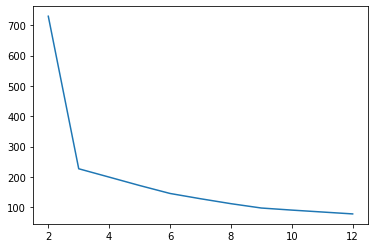

In [45]:
plt.plot(n_clasters, intertias)
plt.show()

####Silhouette

In [46]:
from sklearn.metrics import silhouette_score
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [47]:
data=X
labels=y
n_samples = data.shape
n_features = X
n_digits = np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 14; # samples: (750, 2); # features [[ 0.84022039  1.14802236]
 [-1.15474834 -1.2041171 ]
 [ 0.67863613  0.72418009]
 ...
 [ 0.26798858 -1.27833405]
 [-0.88628813 -0.30293249]
 [ 0.60046048 -1.29605472]]


In [48]:
def bench_k_means(kmeans, name, data, labels):
    
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

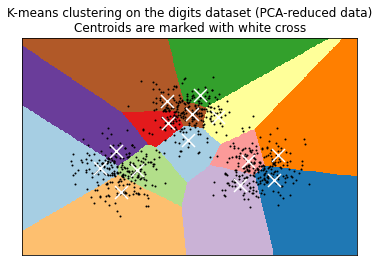

In [49]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(2)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

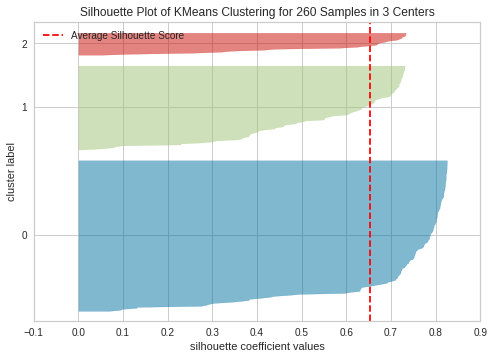

In [50]:
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl


X,y = load_nfl()

# Specify the features to use for clustering
features = ['Rec', 'Yds', 'TD', 'Fmb', 'Ctch_Rate']
xs = X.query('Tgt >= 20')[features]

# Instantiate the clustering model and visualizer
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(xs)        # Fit the data to the visualizer
visualizer.show()